### Load Test Data and Trained APG Sampler

In [1]:
%matplotlib inline
import os
import torch
import numpy as np
from experiments.apgs_bshape.models import init_models
from experiments.apgs_bshape.affine_transformer import Affine_Transformer
from experiments.apgs_bshape.main import train_apg
from experiments.apgs_bshape.gibbs import gibbs_sweeps
from combinators.utils import load_models

data_dir = './dataset/'
timesteps_train = 5
timesteps_test = 10
frame_pixels = 96
shape_pixels = 28
num_objects_train = 3
num_objects_test = 4

device = 'cuda:0'
num_epochs = 1000
lr = 2e-4
batch_size = 5
budget = 120
num_sweeps_train = 5
num_sweeps_test = 5

num_hidden_digit = 400
num_hidden_coor = 400
z_where_dim = 2
z_what_dim = 10

sample_size_test = 2
device = torch.device(device)
sample_size = budget // (num_sweeps_train + 1)
assert sample_size > 0, 'non-positive sample size =%d' % sample_size
mean_shape = torch.load(data_dir + 'mean_shape.pt').to(device)    
data_paths = []
for file in os.listdir(data_dir+'/video/'):
    if file.endswith('.pt') and \
    'timesteps=%d-objects=%d' % (timesteps_test, num_objects_test) in file:
        data_paths.append(os.path.join(data_dir+'/video/', file))
if len(data_paths) == 0:
    raise ValueError('Empty data path list.')
model_version = 'apg-timesteps=%d-objects=%d-sweeps=%d-samples=%d' % (timesteps_train, num_objects_train, num_sweeps_train, sample_size)
models = init_models(frame_pixels, 
                     shape_pixels, 
                     num_hidden_digit, 
                     num_hidden_coor, 
                     z_where_dim, 
                     z_what_dim, 
                     num_objects_test, 
                     mean_shape, 
                     device)
load_models(models, 'cp-' + model_version, map_location=lambda storage, loc: storage)
frames = torch.load(data_paths[0])
indices = torch.randperm(frames.shape[0])
frames = frames[indices[:batch_size]]
frames_expand = frames.repeat(sample_size_test,1,1,1,1).to(device)
apg = gibbs_sweeps(models, num_sweeps_test, timesteps_test)
out = apg(c={"frames": frames_expand}, sample_dims=0, batch_dim=1, reparameterized=False)

In [2]:
def get_samples(out, sweeps, T):
    recon_k = filter(lambda k: 'recon' in k.split("_") and 'opt' not in k.split("_"), out.trace.keys())
    recon_key = next(recon_k)
    recon_vals = out.trace[recon_key].dist.probs
    z_where_vals = []
    for t in range(T):
        z_where_vals.append(out.trace['z_where_%d_%d'%(t,sweeps)].value.unsqueeze(2))
    z_where_vals = torch.cat(z_where_vals, 2)
    return (recon_vals.detach().cpu(), z_where_vals.detach().cpu())

In [3]:
out.trace.log_joint(sample_dims=0, 
                    batch_dim=1, 
                    reparameterized=False).mean()

tensor(-5196.7939, device='cuda:0', grad_fn=<MeanBackward0>)

In [5]:
rs, ws = get_samples(out, num_sweeps_test, timesteps_test)

### Visualize Samples

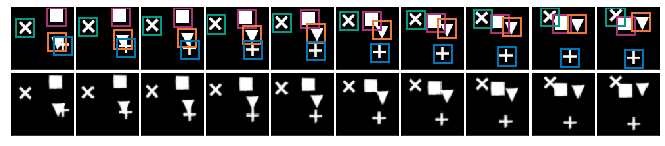

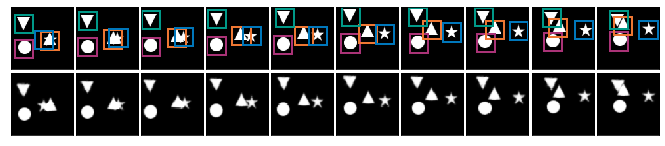

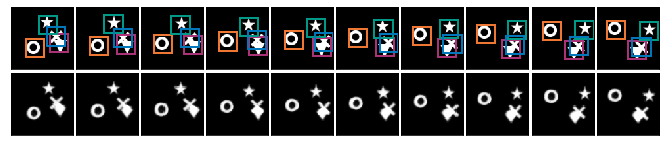

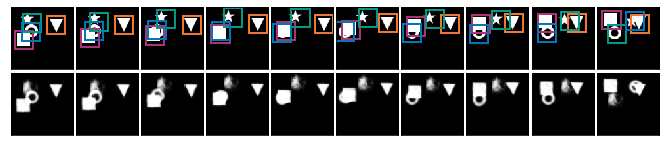

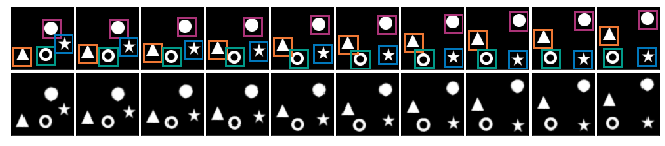

In [6]:
from experiments.apgs_bshape.evaluation import viz_samples
viz_samples(frames, rs, ws, num_sweeps_test, num_objects_test, shape_pixels, fs=1)

### Computing log joint across all methods

In [ ]:
from apgs.bshape.evaluation import density_all_instances
from random import shuffle
sample_size, num_sweeps = 20, 5
lf_step_size, lf_num_steps, bpg_factor = 5e-5, [100], 1
density_all_instances(models, AT, data_paths, sample_size, num_objects, z_where_dim, z_what_dim, num_sweeps, lf_step_size, lf_num_steps, bpg_factor, CUDA, device)

### Computational Budget Analysis

In [ ]:
from apgs.bshape.evaluation import budget_analysis, plot_budget_analyais_results
data = torch.from_numpy(np.load(data_dir + '%dobjects/test/ob-1.npy' % num_objects)).float()
budget = 1000
num_sweeps = np.array([1, 5, 10 , 20, 25])
sample_sizes = 1000 / num_sweeps
blocks = ['decomposed', 'joint']
df = budget_analysis(models, blocks, num_sweeps, sample_sizes, data, num_objects, CUDA, device)
plot_budget_analyais_results(df)

### Comparison with Baselines

In [ ]:
from apgs.bshape.evaluation import density_convergence, plot_convergence
seed = 1
data = torch.from_numpy(np.load(data_dir + '%dobjects/test/ob-1.npy' % num_objects)).float()
sample_size, num_sweeps, num_runs = 100, 30, 3
lf_step_size, lf_num_steps, bpg_factor = 1e-1, [1, 5, 10], 100
densities = density_convergence(models, AT, data, sample_size, num_objects, num_runs, num_sweeps, lf_step_size, lf_num_steps, bpg_factor, CUDA, device)
plot_convergence(densities)

In [ ]:
%matplotlib inline
import torch
import matplotlib.pyplot as plt
from experiments.apgs_bshape.affine_transformer import Affine_Transformer
frame_pixels = 96
digit_pixels = 30
device = torch.device('cpu')
AT = Affine_Transformer(frame_pixels, digit_pixels, device)

In [ ]:
frame = torch.load('./dataset/video_3_1frame/seq-1timesteps-3objects-p1.pt')[0]
print(frame.shape)
plt.imshow(frame[0], cmap='gray', vmin=0.0, vmax=1.0)

In [ ]:
# in-bound case
z_where = torch.zeros(2)
cropped = AT.frame_to_digit(frame.unsqueeze(0).unsqueeze(0), 
                            z_where.unsqueeze(0).unsqueeze(0).unsqueeze(0).unsqueeze(0)).squeeze()
plt.imshow(cropped, cmap='gray', vmin=0, vmax=1)
# print(cropped)

In [ ]:
# partially out-of-bound case
z_where = torch.ones(2)
cropped = AT.frame_to_digit(frame.unsqueeze(0).unsqueeze(0), 
                            z_where.unsqueeze(0).unsqueeze(0).unsqueeze(0).unsqueeze(0)).squeeze()
plt.imshow(cropped, cmap='gray', vmin=0, vmax=1)
# print(cropped)

In [ ]:
# partially out-of-bound case
z_where = torch.ones(2) * 10
cropped = AT.frame_to_digit(frame.unsqueeze(0).unsqueeze(0), 
                            z_where.unsqueeze(0).unsqueeze(0).unsqueeze(0).unsqueeze(0)).squeeze()
plt.imshow(cropped, cmap='gray', vmin=0, vmax=1)
# print(cropped)